# Music Genre Classification on the GTZAN Dataset

The task is to classify music based on their genre by using only audio information.

As the GTZAN dataset is not huge with 100 30-sec tracks per class (10 classes), we need to exploit as much as possible the information that we have. 
The simplest thing to do is to use sliding windows and augment our dataset. Also as representative information lies on the time-frequency representation of an audio signal, it is intriguing to use CNNs. We will experiment with Transfer Learning and see if the feature extraction layers of the architectures that are trained in natural images will benefit us. 

### But first let's import:



In [154]:
import os
import gc
import random
import pandas as pd
import numpy as np
import sklearn
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import librosa
import librosa.display
import IPython.display as ipd

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

import datetime
from tensorboard.plugins.hparams  import api as hp
%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.8/dist-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Then we will browse the dataset and create two lists: one with the class names and the other with the class paths.

In [15]:
path = "genres_original/"

In [16]:
class_paths = [x[0] for x in os.walk(path)][1:]
class_names = [x[1] for x in os.walk(path)][0]

In [17]:
class_names

['classical',
 'jazz',
 'metal',
 'country',
 'reggae',
 'disco',
 'hiphop',
 'blues',
 'rock',
 'pop']

### Now let's check if we can load and listen to the audio correctly:

In [18]:
classic_smpl = os.path.join(class_paths[0], random.choice(os.listdir(class_paths[0])))
metal_smpl = os.path.join(class_paths[2], random.choice(os.listdir(class_paths[2])))

In [19]:
ipd.Audio(classic_smpl)

In [20]:
ipd.Audio(metal_smpl)

### We have loaded two different genre samples: the goal is to explore their characteristics and see if we can find any significant difference in their mel scaled spectrograms

In [21]:
y, sr = librosa.load(classic_smpl)
print("Audio signal shape: ", y.shape)
print("Sample Rate: ", sr)

Audio signal shape:  (661794,)
Sample Rate:  22050


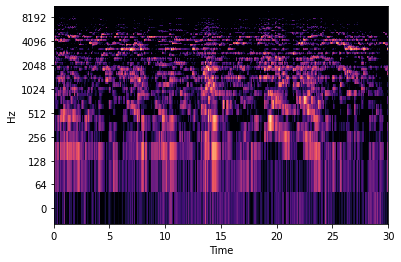

In [22]:
m_spect = librosa.feature.melspectrogram(y=y, sr=sr)
m_spect_db = librosa.amplitude_to_db(m_spect, ref=np.max)
plt.figure()
librosa.display.specshow(m_spect_db, sr=sr, hop_length=512, x_axis = 'time', y_axis = 'log')

In [23]:
y, sr = librosa.load(metal_smpl)
print("Audio signal shape: ", y.shape)
print("Sample Rate: ", sr)

Audio signal shape:  (661504,)
Sample Rate:  22050


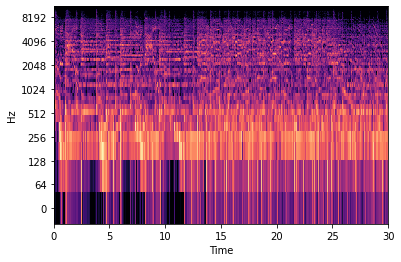

In [24]:
m_spect = librosa.feature.melspectrogram(y=y, sr=sr)
m_spect_db = librosa.amplitude_to_db(m_spect, ref=np.max)
plt.figure()
librosa.display.specshow(m_spect_db, sr=sr, hop_length=512, x_axis = 'time', y_axis = 'log')

### They seem different so let's try to treat them like images and feed them on a CNN to train...


### Before that though we have to split our dataset to train and validation/test. It is important to do this at this stage as we don't want to split the dataset after the windowing. 
### This would be risky as information from the training dataset could leak to the testing and vice versa and thus compromise the integrity of our model.

In [26]:
Xtrain_paths = {}
Xtest_paths = {}
for i, cl in enumerate(class_paths):
    paths = [ os.path.join(cl,track) for track in os.listdir(cl)]
    random.shuffle(paths)
    Xtrain_paths[class_names[i]] = paths[:70]
    Xtest_paths[class_names[i]] = paths[70:]

## SPLITTING AUDIO SIGNALS

### We are using a sliding window with 0.5 overlap to extract audio chuncks from our tracks. Therefore for each track we have ~20 audio signals that are representative (most of the times) and create a better populated dataset. 
### Moreover, by windowing we focus on short time features that could be lost if we used the whole length. 

In [27]:
def split_audio(sgnl, win=0.1, ovrlp=0.5):
    
    shape = sgnl.shape[0]
    smpl_win = int(shape*win)
    smpl_ovrlp = int(smpl_win*(1-ovrlp))

    output_lst = [sgnl[i:i+smpl_win] for i in range(0,shape-smpl_win, smpl_ovrlp)]

    return np.array(output_lst, dtype=float)

In [28]:
ymin = y.shape[0]
for i, cl in enumerate(class_paths):
    for track in os.listdir(cl):
        y, sr = librosa.load(os.path.join(cl,track))
        if y.shape[0]<ymin:
            ymin = y.shape[0]

### Here we extract the mel-scaled spectograms from the training and testing data separately: 

In [29]:
X_train = np.array([])
y_train = np.array([])
for i, cl in enumerate(class_paths):
    print("Processing " + class_names[i] + " music")
    for track in Xtrain_paths[class_names[i]]:
        
        sgnl, sr = librosa.load(track)
        sgnl = sgnl[:ymin]
        sgnl_spl = split_audio(sgnl)
        m_spect = librosa.feature.melspectrogram(y=sgnl_spl, sr=sr)

        X_train = np.concatenate([X_train, m_spect], axis=0) if X_train.size else m_spect
        
        class_labels = np.stack((i,)*m_spect.shape[0])
        y_train = np.concatenate([y_train, class_labels], axis=0) if y_train.size else class_labels 


Processing classical music
Processing jazz music
Processing metal music
Processing country music
Processing reggae music
Processing disco music
Processing hiphop music
Processing blues music
Processing rock music
Processing pop music


In [30]:
X_test = np.array([])
y_test = np.array([])
for i, cl in enumerate(class_paths):
    print("Processing " + class_names[i] + " music")
    for track in Xtest_paths[class_names[i]]:
        
        sgnl, sr = librosa.load(track)
        sgnl = sgnl[:ymin]
        sgnl_spl = split_audio(sgnl)
        m_spect = librosa.feature.melspectrogram(y=sgnl_spl, sr=sr)

        X_test = np.concatenate([X_test, m_spect], axis=0) if X_test.size else m_spect
        
        class_labels = np.stack((i,)*m_spect.shape[0])
        y_test = np.concatenate([y_test, class_labels], axis=0) if y_test.size else class_labels 


Processing classical music
Processing jazz music
Processing metal music
Processing country music
Processing reggae music
Processing disco music
Processing hiphop music
Processing blues music
Processing rock music
Processing pop music


In [31]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

### After we converted our y's to categorical, we need to make the input arrays compatible with the CNN. 
### In order to match the three slices of the 3D image, we replicate each spectrogram three times. 
### There still a better way to adress this by changing the characteristics of the spectogram and create three different versions that will cover better different frequency ranges. Therefore, the CNN will be introduced with more information.


In [32]:
X_train = np.squeeze(np.stack((X_train,) * 3, -1))
X_test = np.squeeze(np.stack((X_test,) * 3, -1))

In [33]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12600, 128, 129, 3) (5382, 128, 129, 3) (12600, 10) (5382, 10)


### The dataset is ready for training, so let's move on to the model selection and design. As said, we are going to use transfer learning, employing natural image trained networks. This is not ideal as the feature extraction on these networks are streamlined towards natural edges. However, the way that transfer learning works with the flexibility of keeping the weights frozen on any layer we want, gives us the option to keep only the first couple of layers and retrain the rest with our dataset. 

### For our experiments, we will use a relative simple DNN architecture VGG16 that has been trained with imagenet images. We are going to remove the top of the network and replace it with our architecture. As there are many parameters to tweak, we are going to use tensorboard and tensorflow's hyperparameter optimisation. In our case, the parameter is kept short to avoid lengthy training times, thus we can use a grid search. However, it is possible for a proper optimisation engine to work. 

### The elements we are trying to optimise are: the units of the dense layer after the VGG16 architecture, the percentage of dropout, and how many layers of the VGG16 we are going to keep. The results and analysis are below: 

In [35]:
# Model Definition
input_shape = X_train[0].shape
num_classes = 10

HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([64, 128, 256]))
HP_DROPOUT = hp.HParam('dropout', hp.Discrete([0.4, 0.6]))
HP_FROZEN = hp.HParam('frozen_layers', hp.Discrete([4, 5, 7]))

METRIC_ACCURACY = 'accuracy'

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_FROZEN],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
  )

def train_test_model(hparams):
    def cnn_vgg16(input_shape, num_classes):
        input_tensor = Input(shape=input_shape)
        vgg16 = VGG16(include_top=False, weights='imagenet',
                      input_tensor=input_tensor)

        top = Sequential()
        top.add(Flatten(input_shape=vgg16.output_shape[1:]))
        top.add(Dense(hparams[HP_NUM_UNITS], activation='relu'))
        top.add(Dropout(hparams[HP_DROPOUT]))
        top.add(Dense(num_classes, activation='softmax'))

        model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
        for layer in model.layers[:hparams[HP_FROZEN]]:
            layer.trainable = False

        return model

    model = cnn_vgg16(input_shape, num_classes)
    print("Creating EarlyStopping Callback ...")
    early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3)
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
    #{i: v.name for i, v in enumerate(model.layers)}
    history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=[early_stopping_callback,
                    tf.keras.callbacks.TensorBoard(log_dir),  # log metrics
                    hp.KerasCallback(log_dir, hparams),# log hparams
                    ])
    

    
    return history.history['val_accuracy'][-1], history, model


In [36]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy, _, _ = train_test_model(hparams)
        accuracy= tf.reshape(tf.convert_to_tensor(accuracy), []).numpy()
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step=1)



In [37]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in HP_DROPOUT.domain.values:
        for frozen in HP_FROZEN.domain.values:
            hparams = {
            HP_NUM_UNITS: num_units,
            HP_DROPOUT: dropout_rate,
            HP_FROZEN: frozen,
                      }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1
            gc.collect()


--- Starting trial: run-0
{'num_units': 64, 'dropout': 0.4, 'frozen_layers': 4}
Creating EarlyStopping Callback ...
Epoch 1/1000
99/99 [==============================] - 20s 137ms/step - loss: 3.7630 - accuracy: 0.2006 - val_loss: 2.0367 - val_accuracy: 0.2319
Epoch 2/1000
99/99 [==============================] - 11s 106ms/step - loss: 1.9874 - accuracy: 0.2622 - val_loss: 1.8973 - val_accuracy: 0.3439
Epoch 3/1000
99/99 [==============================] - 11s 107ms/step - loss: 1.8708 - accuracy: 0.3037 - val_loss: 1.7361 - val_accuracy: 0.3803
Epoch 4/1000
99/99 [==============================] - 11s 108ms/step - loss: 1.7650 - accuracy: 0.3444 - val_loss: 1.6786 - val_accuracy: 0.4032
Epoch 5/1000
99/99 [==============================] - 11s 107ms/step - loss: 1.6871 - accuracy: 0.3718 - val_loss: 1.5501 - val_accuracy: 0.4500
Epoch 6/1000
99/99 [==============================] - 11s 108ms/step - loss: 1.5542 - accuracy: 0.4185 - val_loss: 1.5722 - val_accuracy: 0.4690
Epoch 7/1000
9

### Using tensorboard and Hparams, we can visualise the parameter combination that offer the best scores in validation accuracy. We started with a wider range of parameters and finetuned on a less wide parameter space: 
![First run of parameter optimisation](assets/images/TensorBoard_sl.png "First run of parameter optimisation")

### An important insight that this figure gives, is that the more layers we fix to the VGG16, the worst the results are. However if we keep only the minimum the results are satisfying.

![First run of parameter optimisation](assets/images/TensorBoard_sl_ft.png "First run of parameter optimisation")

### The parameters that were chosen are shown below: 

In [39]:
hparams = {
HP_NUM_UNITS: 256,
HP_DROPOUT: 0.40,
HP_FROZEN: 5,
          }

accuracy, hist, model = train_test_model(hparams)

Creating EarlyStopping Callback ...
Epoch 1/1000
99/99 [==============================] - 11s 110ms/step - loss: 3.0573 - accuracy: 0.2212 - val_loss: 1.9605 - val_accuracy: 0.2876
Epoch 2/1000
99/99 [==============================] - 10s 99ms/step - loss: 1.8418 - accuracy: 0.3142 - val_loss: 1.7383 - val_accuracy: 0.3800
Epoch 3/1000
99/99 [==============================] - 10s 99ms/step - loss: 1.6760 - accuracy: 0.3853 - val_loss: 1.6060 - val_accuracy: 0.4344
Epoch 4/1000
99/99 [==============================] - 10s 100ms/step - loss: 1.4477 - accuracy: 0.4783 - val_loss: 1.4526 - val_accuracy: 0.5046
Epoch 5/1000
99/99 [==============================] - 10s 100ms/step - loss: 1.2468 - accuracy: 0.5593 - val_loss: 1.2950 - val_accuracy: 0.5665
Epoch 6/1000
99/99 [==============================] - 10s 100ms/step - loss: 1.1017 - accuracy: 0.6067 - val_loss: 1.2898 - val_accuracy: 0.5478
Epoch 7/1000
99/99 [==============================] - 10s 100ms/step - loss: 0.9776 - accuracy: 

In [40]:
model.save('genre_class_vgg16_hyp.h5')

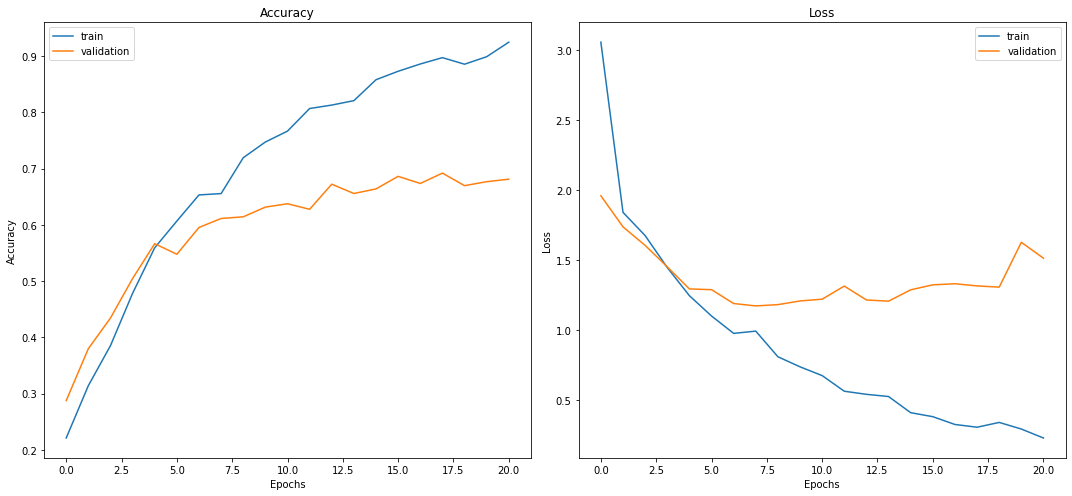

In [41]:
plt.figure(figsize=(15,7))


plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig("acc_loss_vgg16")
plt.tight_layout()
plt.show()



### We achieve around 70% validation accuracy with this setup which might not be ideal but it shows some promise. The problem here is that the training was automatically stopped by the earlystopper callback as it is close to overffiting. The gap between the validation and the train accuracy curve tells us that the training dataset might be unrepresentative and while the network learns from it the validation dataset is not following with the same pace. We can introduce more dropout or some regularisation to see if we can tackle this, but a better variety in the song dataset would be more beneficial.

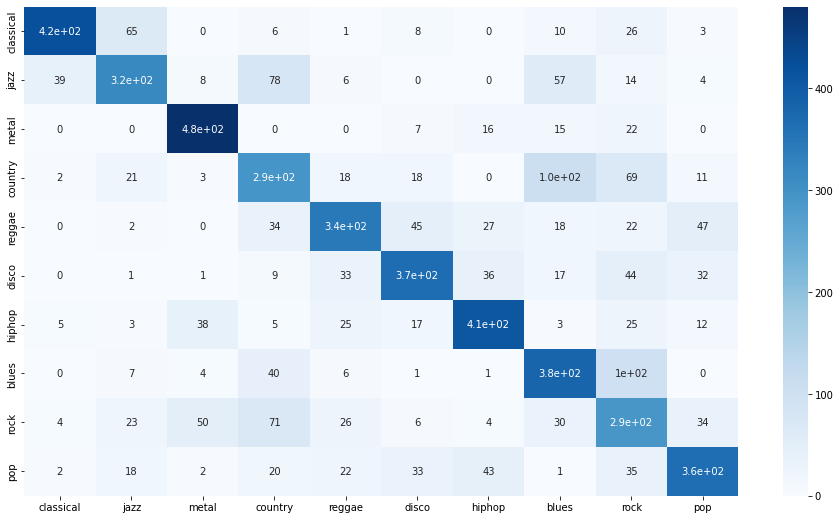

In [42]:
preds = model.predict(X_test)

predictions = np.argmax(preds, axis=1)
y_test_labels =  np.argmax(y_test, axis=1)

# Confusion Matrix
confusion_matr = tf.math.confusion_matrix(y_test_labels, predictions, num_classes=10)
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = class_names,
           yticklabels=class_names);
plt.savefig("conf matrix")

### This is the confusion matrix for the windowed samples to identify the weak points. The poor performers are country and rock while the metal is the top performer. 

### However we are not going to stop here and we are going to find how the classifier perform on the whole track. We expect better than 70% accuracy as we can classify through the pieces of the track and decide on the majority which is the class. 

In [44]:
def classify_track(path, model):
    sgnl, sr = librosa.load(path)
    sgnl = sgnl[:ymin]
    sgnl_spl = split_audio(sgnl)
    m_spect = librosa.feature.melspectrogram(y=sgnl_spl, sr=sr)
    X = np.squeeze(np.stack((m_spect,) * 3, -1))
    prediction = list(np.argmax(model.predict(X), axis=1))
    
    return max(set(prediction), key = prediction.count)
   

In [45]:
y_pred = []
y_real = []
for i, cl in enumerate(class_paths):
    print("Processing " + class_names[i] + " music")
    for track in Xtest_paths[class_names[i]]:
        y_pred.append(classify_track(track, model))
        y_real.append(i)

Processing classical music
Processing jazz music
Processing metal music
Processing country music
Processing reggae music
Processing disco music
Processing hiphop music
Processing blues music
Processing rock music
Processing pop music


Final result:  0.76254183


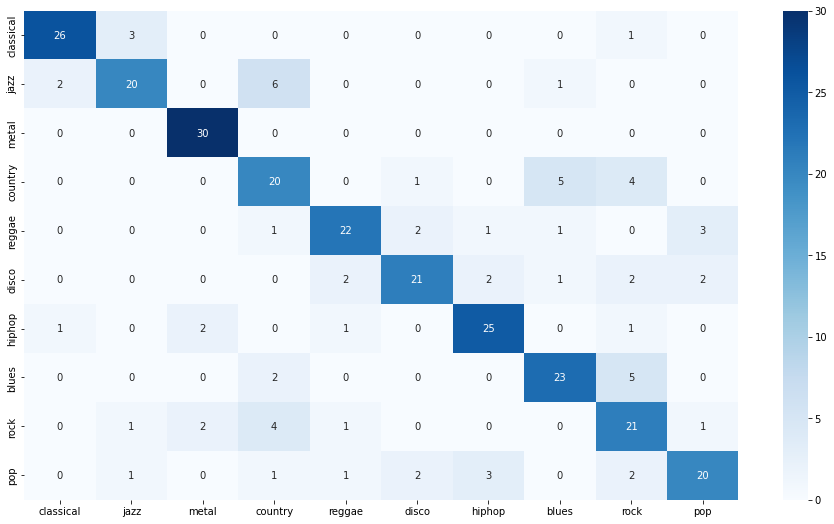

In [46]:
confusion_matr = tf.math.confusion_matrix(y_real, y_pred, num_classes=10)
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = class_names,
           yticklabels=class_names);
plt.savefig("conf matrix_tracks")

m = tf.keras.metrics.Accuracy()
m.update_state(y_real, y_pred)
print('Final result: ', m.result().numpy())

### Indeed the results are better reaching 76% accuracy.

### Let's see if we can get something more by introducing extra features to the model. With this in mind we extract some audio features like MFCCs, Spectral Centroid, Bandwidth and rolloff as well as zero-crossings and tempo. We form feature vectors for every windowed chunk of audio and feed some classic ML methods. 

In [75]:
def extract_audio_feats(sgnl_spl):
    feat_vec = np.array([])
    for i in range(sgnl_spl.shape[0]):
        mfccs =librosa.feature.mfcc(y=sgnl_spl[i,:])
        mfccs_mv = np.expand_dims(np.concatenate([mfccs.mean(axis=1), mfccs.var(axis=1)]),axis=0)

        centr = librosa.feature.spectral_centroid(y=sgnl_spl[i,:])
        centr_mv = np.expand_dims(np.concatenate([centr.mean(axis=1), centr.var(axis=1)]),axis=0)

        rolloff = librosa.feature.spectral_rolloff(y=sgnl_spl[i,:])
        roll_mv = np.expand_dims(np.concatenate([rolloff.mean(axis=1), rolloff.var(axis=1)]),axis=0)

        bandw = librosa.feature.spectral_bandwidth(y=sgnl_spl[i,:])
        bandw_mv = np.expand_dims(np.concatenate([bandw.mean(axis=1), bandw.var(axis=1)]),axis=0)

        zero_crossings = librosa.zero_crossings(sgnl_spl[i,:], pad=False)MLPC
        tempo, _ = librosa.beat.beat_track(y=sgnl_spl[i,:])
        zer_tempo = np.expand_dims(np.array([np.sum(zero_crossings), tempo]),axis=0)

        feats =  np.concatenate([mfccs_mv, centr_mv, roll_mv, bandw_mv, zer_tempo], axis=1)

        feat_vec = np.concatenate([feat_vec, feats], axis=0) if feat_vec.size else feats
    return feat_vec

In [76]:
X_train = np.array([])
y_train = np.array([])
for i, cl in enumerate(class_paths):
    print("Processing " + class_names[i] + " music")
    for track in Xtrain_paths[class_names[i]]:
        
        sgnl, sr = librosa.load(track)
        sgnl = sgnl[:ymin]
        sgnl_spl = split_audio(sgnl)
        feat_vec = extract_audio_feats(sgnl_spl)

        X_train = np.concatenate([X_train, feat_vec], axis=0) if X_train.size else feat_vec
        
        class_labels = np.stack((i,)*m_spect.shape[0])
        y_train = np.concatenate([y_train, class_labels], axis=0) if y_train.size else class_labels 


Processing classical music
Processing jazz music
Processing metal music
Processing country music
Processing reggae music
Processing disco music
Processing hiphop music
Processing blues music
Processing rock music
Processing pop music


In [77]:
X_test = np.array([])
y_test = np.array([])
for i, cl in enumerate(class_paths):
    print("Processing " + class_names[i] + " music")
    for track in Xtest_paths[class_names[i]]:
        
        sgnl, sr = librosa.load(track)
        sgnl = sgnl[:ymin]
        sgnl_spl = split_audio(sgnl)
        feat_vec = extract_audio_feats(sgnl_spl)

        X_test = np.concatenate([X_test, feat_vec], axis=0) if X_test.size else feat_vec
        
        class_labels = np.stack((i,)*m_spect.shape[0])
        y_test = np.concatenate([y_test, class_labels], axis=0) if y_test.size else class_labels 


Processing classical music
Processing jazz music
Processing metal music
Processing country music
Processing reggae music
Processing disco music
Processing hiphop music
Processing blues music
Processing rock music
Processing pop music


In [78]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12600, 48) (5382, 48) (12600,) (5382,)


In [79]:
min_max_scaler = sklearn.preprocessing.MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [155]:
kNN = KNeighborsClassifier(n_neighbors=25)
SVM = SVC()
RFC = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
MLPC = MLPClassifier(alpha=1e-4, hidden_layer_sizes=(1024, 256, 32), random_state=1)
XGB = XGBClassifier(n_estimators=1000, learning_rate=0.05)

In [110]:
kNN.fit(X_train, y_train)
preds = kNN.predict(X_test)
print('Accuracy:', sklearn.metrics.accuracy_score(y_test, preds), '\n')

Accuracy: 0.5930880713489409 



In [ ]:
SVM.fit(X_train, y_train)
preds = SVM.predict(X_test)
print('Accuracy:', sklearn.metrics.accuracy_score(y_test, preds), '\n')


Accuracy: 0.6321070234113713 



In [112]:
RFC.fit(X_train, y_train)
preds = RFC.predict(X_test)
print('Accuracy:', sklearn.metrics.accuracy_score(y_test, preds), '\n')


Accuracy: 0.592530657748049 



In [162]:
MLPC.fit(X_train, y_train)
preds = MLPC.predict(X_test)MLPC
print('Accuracy:', sklearn.metrics.accuracy_score(y_test, preds), '\n')


Accuracy: 0.6293199554069119 



In [156]:
XGB.fit(X_train, y_train)
preds = XGB.predict(X_test)
print('Accuracy:', sklearn.metrics.accuracy_score(y_test, preds), '\n')


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:47:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.6495726495726496 



### As the performance is not better than the CNN model before, we don't expect to get better results from the ensemble of methods. However, we test it to make sure that the extra classification results are not providing information to improve the overal accuracy.

In [163]:
def classify_track_ensemble(path, model, XGB, SVM, MLPC):
    sgnl, sr = librosa.load(path)
    sgnl = sgnl[:ymin]
    sgnl_spl = split_audio(sgnl)
    m_spect = librosa.feature.melspectrogram(y=sgnl_spl, sr=sr)
    X = np.squeeze(np.stack((m_spect,) * 3, -1))
    pred_DL = list(np.argmax(model.predict(X), axis=1))
    

    feat_vec = extract_audio_feats(sgnl_spl)
    feat_vec = min_max_scaler.transform(feat_vec)
    
    pred_XGB = XGB.predict(feat_vec)
    pred_SVM = SVM.predict(feat_vec)
    pred_MLPC = MLPC.predict(feat_vec)
    
    
    predictions= [pred_DL, pred_XGB, pred_SVM, pred_MLPC]
    result = scipy.stats.mode(np.stack(predictions), axis=0)
    hard_vot = list(np.squeeze(result.mode))
    pred_DL = max(set(hard_vot), key = hard_vot.count)
    return pred_DL

In [164]:
y_pred = []
y_real = []
for i, cl in enumerate(class_paths):
    print("Processing " + class_names[i] + " music")
    for track in Xtest_paths[class_names[i]]:
        y_pred.append(classify_track_ensemble(track, model, XGB, SVM, MLPC))
        y_real.append(i)

Processing classical music
Processing jazz music
Processing metal music
Processing country music
Processing reggae music
Processing disco music
Processing hiphop music
Processing blues music
Processing rock music
Processing pop music


Final result:  0.74916387


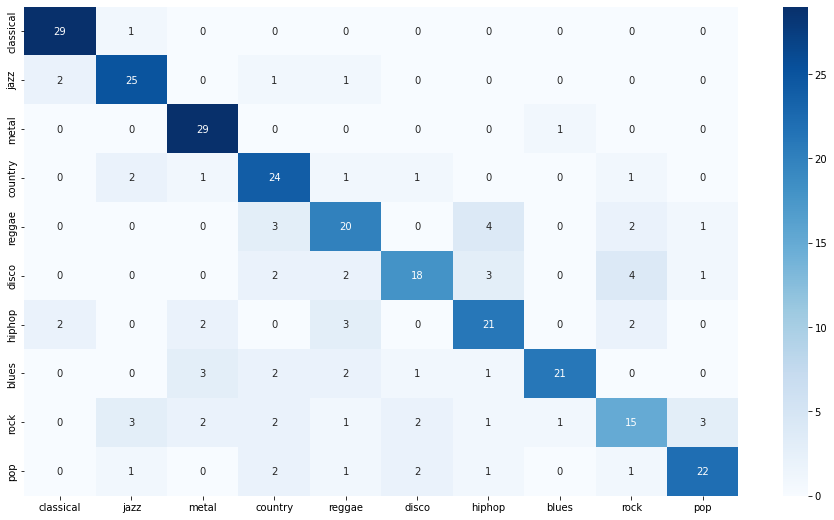

In [165]:
confusion_matr = tf.math.confusion_matrix(y_real, y_pred, num_classes=10)
plt.figure(figsize = (16, 9))
sns.heatmap(confusion_matr, cmap="Blues", annot=True, 
            xticklabels = class_names,
           yticklabels=class_names);
plt.savefig("conf matrix_tracks_ensemble")

m = tf.keras.metrics.Accuracy()
m.update_state(y_real, y_pred)
print('Final result: ', m.result().numpy())